## Arima 모델 만들기

trend : constant를 가지고 있는지, c - constant / nc - no constant

disp : 수렴 정보를 나타냄(정확히 뭐를 나타내는 것인지 모르겠음, 크게 중요한 사항은 아닌듯 함)

-------------------------------------------

이전 포스팅에서는 정상 시계열인지 확인을 하고

비정상 시계열 데이터를 차분 한 뒤, 정상 시계열이 됬는지를 확인하였습니다.

이제 정상 시계열임을 확인하였으니 ARIMA로 예측 모형을 만드는 과정에 대해 포스팅 합니다.

그래프 상에서는 차분 1번 이후에 추가적으로 AR, MA를 0으로 하고 진행을 하여도 되지만

최적의 모형을 찾는 과정을 설명하기 위해,  일단(AR=0, 차분=1, MA=1) 파라미터로 ARIMA 모델을 학습합니다.

In [6]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3036.684
Method:                       css-mle   S.D. of innovations            993.013
Date:                Wed, 10 Mar 2021   AIC                           6079.369
Time:                        23:08:13   BIC                           6091.068
Sample:                    03-03-2020   HQIC                          6084.018
                         - 03-02-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           112.4754     50.926      2.209      0.027      12.663     212.288
ma.L1.D.price    -0.0204      0.052     -0.391      0.696      -0.123       0.082
                                    Root

‘P > z’ 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값이다. 

여기서 만약 const의  p value 0.05 이상이라면, 

model.fit()의 파라미터중 trend=’c’가 아니라 ‘nc’로 설정해주어야 하는게 옳다.

즉 시계열 모형에 상수 값이 필요하지 않다는 것을 의미한다.

여기서는 const가 아닌 그래프 상에서는 필요하지 않았지만 임의로 추가하였던 MA1이 귀무가설 채택인 상태이므로

이를 제외하고 다시 모형을 만들었다.

In [7]:
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3036.760
Method:                           css   S.D. of innovations            993.220
Date:                Wed, 10 Mar 2021   AIC                           6077.520
Time:                        23:08:13   BIC                           6085.320
Sample:                    03-03-2020   HQIC                          6080.620
                         - 03-02-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.5596     51.988      2.165      0.030      10.666     214.453


확실히 MA1이 추가된 모형보다 그냥 차분만 하고 ARMIA(0,1,0)을 한 모형이 AIC, BIC 값이 더 작다.

const에 대한 pvalue도 귀무가설 기각 상태이므로 해당 변수가 유의하다는 뜻이다.

만약 이렇게 모형을 일일히 만들어서 하는 것이 아닌 r에서의 auto arima를 통해서 결과를 비교하고 싶다면

아래와 같은 방식으로 수행을 하여야 한다.

먼저 R에서의 auto arima 방식이다.

---------------------------------------

library(forecast)

auto.arima(data)

---------------------------------------

이렇게 실행한 다음에, 나온 AR,차분여부,MA 값으로 모델을 만들고 예측을 하면 된다.

R은 이렇게 간단하지만, python은 auto arima를 가능하게 해주는 패키지가 ADP에서는 제공이 안된다.

밑에는 파이썬으로 arima를 for문을 이용해서 모든 경우의 수를 이용하여서 생성하고 AIC 값을 이용해서

최적의 모형을 찾아주는 방법이다.

In [8]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q))

                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)),
                                         columns=['order', 'AIC'])
                result_df.sort_values(sort, inplace=True)

    return result_df


my_auto_arima(series, [2, 2, 2])

,order,AIC
2,p0 d1 q0,6077.520333
5,p1 d1 q0,6079.360565
3,p0 d1 q1,6079.368511
6,p1 d1 q1,6081.343064
4,p1 d0 q0,6106.900505
1,p0 d0 q1,7444.572662
0,p0 d0 q0,7910.861125


차분을 1번이라도 한 게, 차분을 안 한 것보다는 AIC값이 더 낮았고,

최적의 모형은 역시 차분만 하고 AR, MA는 안 한 모형으로 나온 것이 확인 되었다.

그 다음은 기존 날짜의 예측값과 실제 값을 비교해서 시각화 하고

forecast로 그 이후에 몇일까지를 예측할 것인지 지정을 해주면 실제 예측 값이 나오는 방식이다.

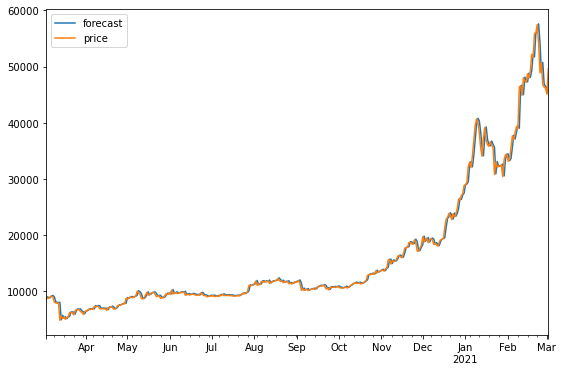

(array([49730.98961644, 49843.54923288, 49956.10884932, 50068.66846575,
       50181.22808219]), array([ 993.22014229, 1404.62539564, 1720.30774954, 1986.44028457,
       2220.90775477]), array([[47784.31390884, 51677.66532404],
       [47090.53404565, 52596.56442011],
       [46584.36761789, 53327.85008074],
       [46175.31705055, 53962.01988095],
       [45828.32886985, 54534.12729453]]))


In [9]:
model_fit.plot_predict()
plt.show()

fore = model_fit.forecast(steps=5)
print(fore)

## 잔차 분석

최적의 모델에서 나온 잔차를 그래프로 그려보고 acf, pacf를 분석을 통해 잔차가 정상성을 가지는지 확인해보고

qqplot과 shapiro test, normaltest로 정규분포 형태를 가지는지 확인 해보고

마지막으로 durbin_watson 검증을 통해서 잔차의 자기상관 관계 여부를 확인해보았다.

In [18]:
def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()

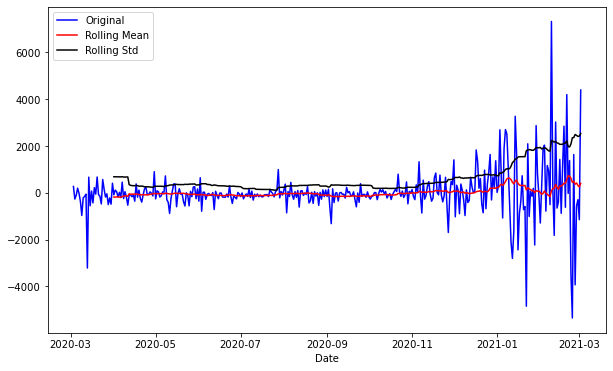

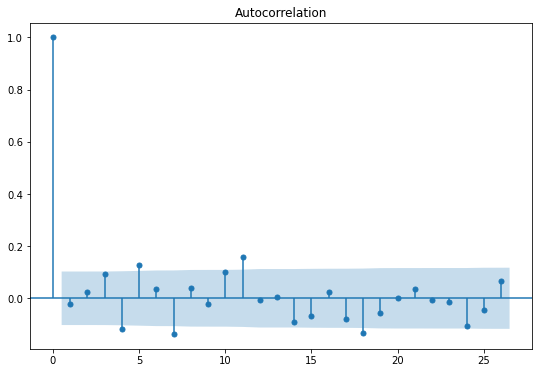

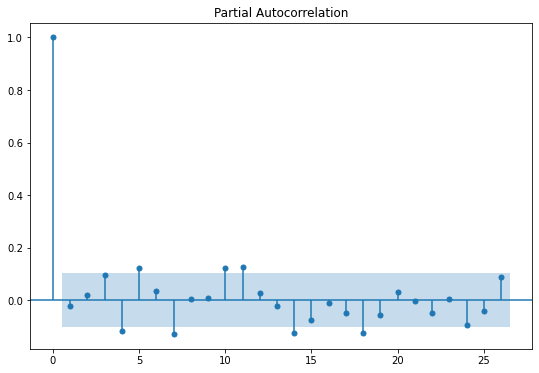

In [19]:
plt.rcParams['figure.figsize'] = [9, 6]
plot_rolling(model_fit.resid, 30)
plot_acf(model_fit.resid)
plot_pacf(model_fit.resid)
plt.show()

잔차의 그래프만 확인해보면, 1차 차분을 한 것과 모양이 굉장히 흡사하다.

평균을 일정해 보이는 것이 확인이 되었고, 분산의 경우, 마지막 부분에 왔다갔다 하는 값이 크기 때문에 분산이 일정하다고는 말 할 수 없을 것으로 보인다.

정상성을 추가로 확인하기 위해서, ACF, PACF 표를 확인해본 결과, 두 그래프에서 모두 절단점이 발견되지 않아

정상 시계열일 것으로 추측할 수 있다.

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(model_fit.resid)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -5.660
원 데이터 p-value: 0.000


ADF 검증을 통해서 확인해본 결과, pvalue가 매우 작으므로, 귀무가설인 비정상 시계열임을 기각하고

정상 시계열임을 채택할 수 있다.

그리고 잔차가 정규분포인지를 확인해보는 것의 경우, 아래와 같은 결과가 나왔는데

시각화를 해서 봤을 때는, 어느 정도는 정규분포를 따르는 모습으로 보이기는 하지만

shapiro wilk test와 normaltest를 통해서 수행한 결과에서는 모두 pvalue가 매우 작아서

귀무가설인 해당 잔차가 정규분포를 따른다는 가설을 기각하게 된 모습을 확인할 수 있었다.

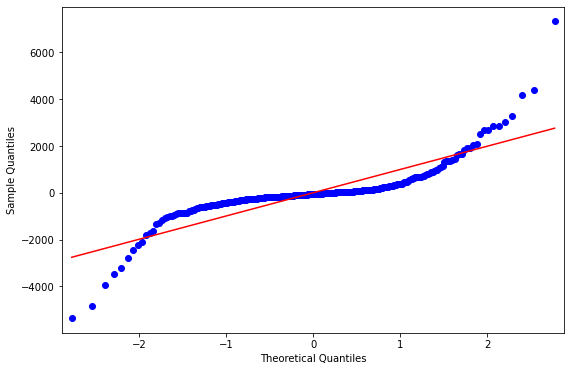

Statistics=0.730, p=0.000
Sample does not look Gaussian (reject H0)
----------------
Statistics=126.455, p=0.000
Sample does not look Gaussian (reject H0)


In [20]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest

qqplot(model_fit.resid, line='s')
plt.show()

stat1, p1 = shapiro(model_fit.resid)
print('Statistics=%.3f, p=%.3f' % (stat1, p1))
# interpret
alpha = 0.05
if p1 > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

print("----------------")

stat2, p2 = normaltest(model_fit.resid)
print('Statistics=%.3f, p=%.3f' % (stat2, p2))
# interpret
alpha = 0.05
if p2 > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

마지막으로 잔차가 자기상관관계를 가지고 있는지 확인하기 위해서 durbin watson 검증을 수행한 결과

2에 가까운 값을 가진 것으로 확인 하였다.

2에 가까울수록 auto correlation을 가지고 있지 않다는 가설을 채택할 수 있다.

pvalue는 R 처럼 나오지 않기에, 값이 2에 얼마나 가까운지를 통해서 결론을 도출하여야 한다.

0에 가까우면 양의 auto correlation, 4에 가까우면 음의 auto correlation을 가진다.

In [14]:
#자기상관
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model_fit.resid)

1.9869860884341106

## cf1) SARIMA 사용시

19회 ADP 실기 시험에서 SARIMA가 나왔다는 이야기가 있어서

일단은 추가로 포스팅을 해본다.

딱히 나올 가능성이 크지는 않을 것으로 보인다.

나와도 어차피 공식 문서를 활용해서 충분히 구현 가능할 것으로 보인다.

In [16]:
import statsmodels.api as sm
from tqdm import tqdm
import itertools
# Grid Search
p = d = q = range(0,2) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 12 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []
# Grid Search Continued
for combination in tqdm(pdq):
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(series, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)
# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(series, order=combs[best_aic][0], seasonal_order=combs[best_aic][1],
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model = model.fit()
model.summary()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.66s/it]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                  366
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2841.303
Date:                            Wed, 10 Mar 2021   AIC                           5690.606
Time:                                    23:08:48   BIC                           5705.910
Sample:                                03-02-2020   HQIC                          5696.705
                                     - 03-02-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8834      0.085    -10.434      0.000      -1.049      -0.717
ma.L1          0.9155      0.074     12.310      0.000       0.770       1.061
ma.S.L12      -0.9451      0.038    -25.004      0.000      -1.019      -0.871
sigma2      1.053e+06   3.83e+04     27.462      0.000    9.78e+05    1.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):              2460.19
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):              22.13   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""